<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/instance_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
!unzip -o -d ./images MP6843_img_full.zip
!unzip -o -d ./labels MP6843_seg.zip
!rm *.zip

--2021-08-03 08:55:12--  https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240194618 (229M) [application/zip]
Saving to: ‘MP6843_img_full.zip’

MP6843_img_full.zip 100%[===================>] 229.07M  3.04MB/s    in 58s     

2021-08-03 08:56:12 (3.97 MB/s) - ‘MP6843_img_full.zip’ saved [240194618/240194618]

--2021-08-03 08:56:12--  https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, aw

In [3]:
import numpy as np
from os import listdir
from os.path import join
import cv2

In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
num_classes = 2
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [5]:
im_root, lb_root = "./images", "./labels"
im_files = [join(im_root, im) for im in sorted(listdir(im_root)) if 'w1' in im]
lb_files = [join(lb_root, lb) for lb in sorted(listdir(lb_root)) if '_01' in lb]

In [6]:
dim = (696, 520)
images = np.array([cv2.resize(cv2.imread(img), dim, interpolation = cv2.INTER_AREA) for img in im_files])
labels = np.array([cv2.imread(lbl, 0) for lbl in lb_files]) / 255

In [ ]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(256),
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.transform(self.images[ind])
        lbl = self.transform(self.labels[ind])

        return img, lbl

In [ ]:
lb_files[2]

'./labels/F01_1377_GT_01.tif'

In [21]:
import sys

array = labels[2][1:256, 1:256]
cells = np.where(array > 0.5)
full_x, full_y = cells
cells = list(zip(full_x, full_y))

instance = np.zeros_like(array)
current_inst = 1


def find_nb(col, row):
    x1 = (col - 1) if col > 0 else col
    x2 = (col + 1) if col <= len(cells) else col
    y1 = (row - 1) if row > 0 else row
    y2 = (row + 1) if row <= len(cells) else row

    neigh = [(c, r) for c in range(x1, x2+1) for r in range(y1, y2+1)]
    neigh.remove((col, row))
    return neigh

def recurt(x, y, current_inst):
    instance[x, y] = current_inst
    neigh = find_nb(x, y)
    friends = list(set(neigh) & set(cells))

    if (x, y) in cells: cells.remove((x, y))
    for (xf, yf) in friends:
        recurt(xf, yf, current_inst)

    current_inst += 1
    return current_inst

for i in cells:
    xc, yc = i
    current_inst = recurt(xc, yc, current_inst)

print(np.unique(instance))
print(current_inst)

[0. 1. 2. 3.]
4


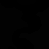

In [22]:
from PIL import Image
Image.fromarray(np.uint8(instance))